In [1]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Reshape, Dropout, Conv2D, Activation
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
alpha = 1.0
n_classes = 2
dropout = 1e-3

K.clear_session() # Clear previous models from memory.

# Load MobileNet without the final fully connected layer.

base_model = MobileNet(input_shape=(96, 96, 3),
                       alpha=alpha,
                       depth_multiplier=1,
                       dropout=dropout,
                       include_top=False,
                       weights=None, #'imagenet',
                       pooling=None)

# Add the final layers.

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Reshape((1, 1, int(1024 * alpha)), name='reshape_1')(x)
x = Dropout(dropout, name='dropout')(x)
x = Conv2D(n_classes,
           (1, 1),
           padding='same',
           name='conv_preds')(x)
x = Activation('softmax', name='act_softmax')(x)
x = Reshape((n_classes,), name='reshape_2')(x)

model = Model(inputs=base_model.input, outputs=x)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
train_x_path = '../../Downloads/camelyonpatch_level_2_split_train_x.h5'
train_y_path = '../../Downloads/camelyonpatch_level_2_split_train_y.h5'

train_x = HDF5Matrix(datapath=train_x_path, dataset='x', start=0, end=None)
train_y = HDF5Matrix(datapath=train_y_path, dataset='y', start=0, end=None)

In [4]:
print(type(train_x))
print(train_y.shape)

<class 'keras.utils.io_utils.HDF5Matrix'>
(262144, 1, 1, 1)


In [5]:
train_dataset = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=True,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=True,
                                   zca_whitening=False,
                                   zca_epsilon=1e-06,
                                   rotation_range=0.0,
                                   width_shift_range=0.0,
                                   height_shift_range=0.0,
                                   brightness_range=None,
                                   shear_range=0.0,
                                   zoom_range=0.0,
                                   channel_shift_range=0.0,
                                   fill_mode='nearest',
                                   cval=0.0,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale=None,
                                   preprocessing_function=None,
                                   data_format=None,
                                   validation_split=0.0)

In [ ]:
train_generator = train_dataset.flow(x=train_x,
                                     y=train_y,
                                     batch_size=32,
                                     shuffle=True,
                                     seed=None)

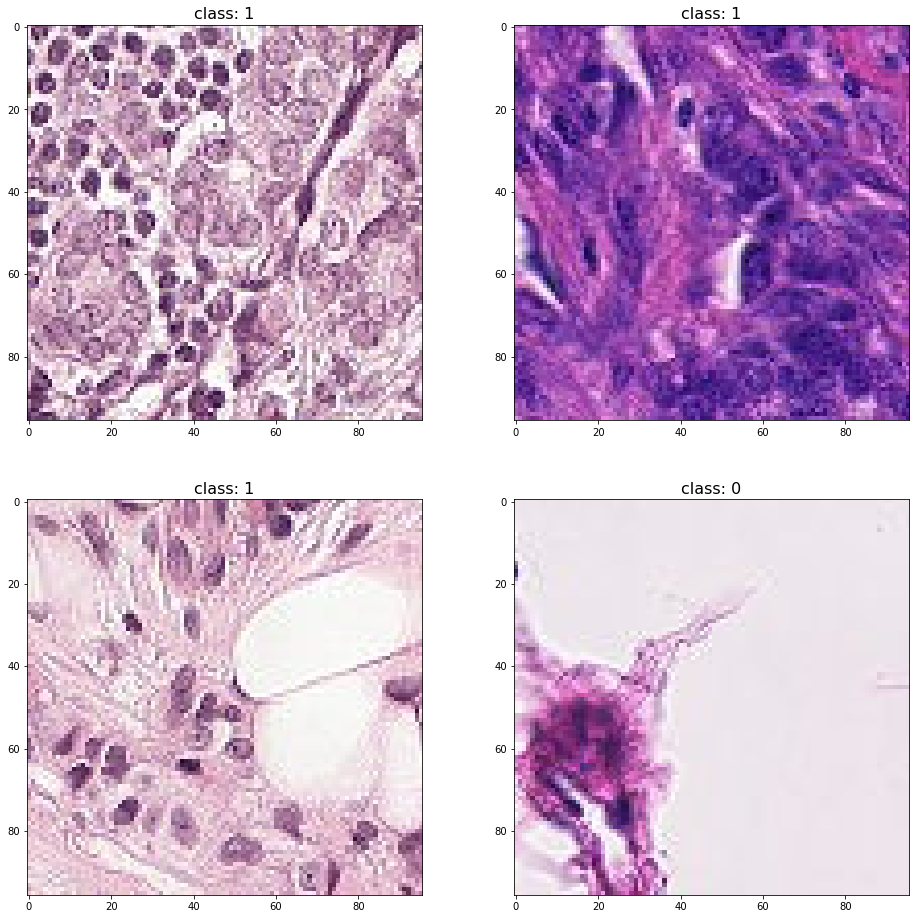

In [13]:
i = 1
m = 2
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
cells[0,0].imshow(train_x[i])
cells[0,0].set_title('class: {}'.format(str(np.squeeze(train_y[i]))), fontsize=16)
cells[0,1].imshow(train_x[i+1])
cells[0,1].set_title('class: {}'.format(str(np.squeeze(train_y[i+1]))), fontsize=16)
cells[1,0].imshow(train_x[i+2])
cells[1,0].set_title('class: {}'.format(str(np.squeeze(train_y[i+2]))), fontsize=16)
cells[1,1].imshow(train_x[i+3])
cells[1,1].set_title('class: {}'.format(str(np.squeeze(train_y[i+3]))), fontsize=16)